# Pneumonia detection Challenge form Kaggle

In [2]:
# Import necessary modules and libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path

In [3]:
# Set up path to keep the dataset at
data_folder = Path('data')
data_file = data_folder/'pneumonia_dataset'


# We have a downloaded zip file of dataset. It will extract the zip file unless it is already extracted and the directory exists. 
if data_file.is_dir():
    print('Directory already exists. Skipping zip file extraction....')
else:
    with zipfile.ZipFile(data_folder/'rsna-pneumonia-detection-challenge.zip', 'r') as zip_ref:
        zip_ref.extractall(data_file)

Directory already exists. Skipping zip file extraction....


In [4]:
# Get and store all the path for the train and test data. Also `all_images_path` variable to store all the paths for all data (train and test data)

train_images_path = list(data_file.glob('stage_2_train_images/*.dcm'))
test_images_path = list(data_file.glob('stage_2_test_images/*.dcm'))
all_images_path = list(data_file.glob('*/*.dcm'))

In [5]:
print(f'Total number of Training Data: {len(train_images_path)} \nTotal number of Testing Data: {len(test_images_path)}\nTotal number of Data: {len(all_images_path)}')

Total number of Training Data: 26684 
Total number of Testing Data: 3000
Total number of Data: 29684


Text(0.5, 1.0, 'PatientID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6')

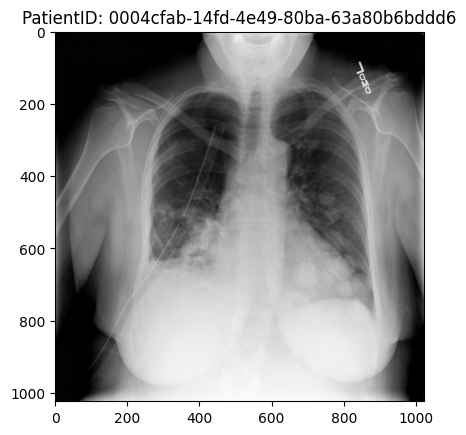

In [6]:
# Print out a sample data

import pydicom

image = pydicom.dcmread(train_images_path[0])
image_pixel = image.pixel_array
plt.imshow(image_pixel, cmap='grey')
plt.title(f'PatientID: {image.PatientID}')

In [7]:
# File path of the labels

label_file = data_file/'stage_2_train_labels.csv'
label_file

WindowsPath('data/pneumonia_dataset/stage_2_train_labels.csv')

## The order of data and the labels do not match. So work to make them in correct order so the index of the data correspond to the index of the label

## Working with label document of test images which is a CSV file with `pandas`

In [8]:
### storing all the labels form the label document into the 'df_train_label_file'

In [9]:
import pandas as pd

# read the label csv file into the 'df_label_file' variable
df_label_file = pd.read_csv(label_file)
display(df_label_file[:5])

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [10]:
rows = 2
columns = 5

import random
# Sample random int from a index equalling the lenght of train data 
rand_int_list = random.sample(range(len(train_images_path)), k=rows*columns)

# Create a dict for label 0 and 1 which correspond to Pneumonia Absent and Present
labels_dict = {0: 'Absent',
               1: 'Present'}

labels_dict[0], labels_dict[1]

('Absent', 'Present')

In [11]:
# # The follwing label is incorrect because the data patientId and label patientId are not in order

# # get all the labels from the label file and store it in the 'all_labels_list' list

# labels_o_list = []

# import csv

# with open(label_file) as csvfile:
#     csv_reader = csv.reader(csvfile)

#     # Calling this will also store the header of the CSV file in the `header` variable and the next time we call `csv_reader` we will have directly access to the data values
#     header = next(csv_reader)
#     print(header)

#     label_index = header.index('Target')

#     for row in csv_reader:
    
#         labels = int(row[label_index])
#         labels_o_list.append(labels)

# # labels_o_list

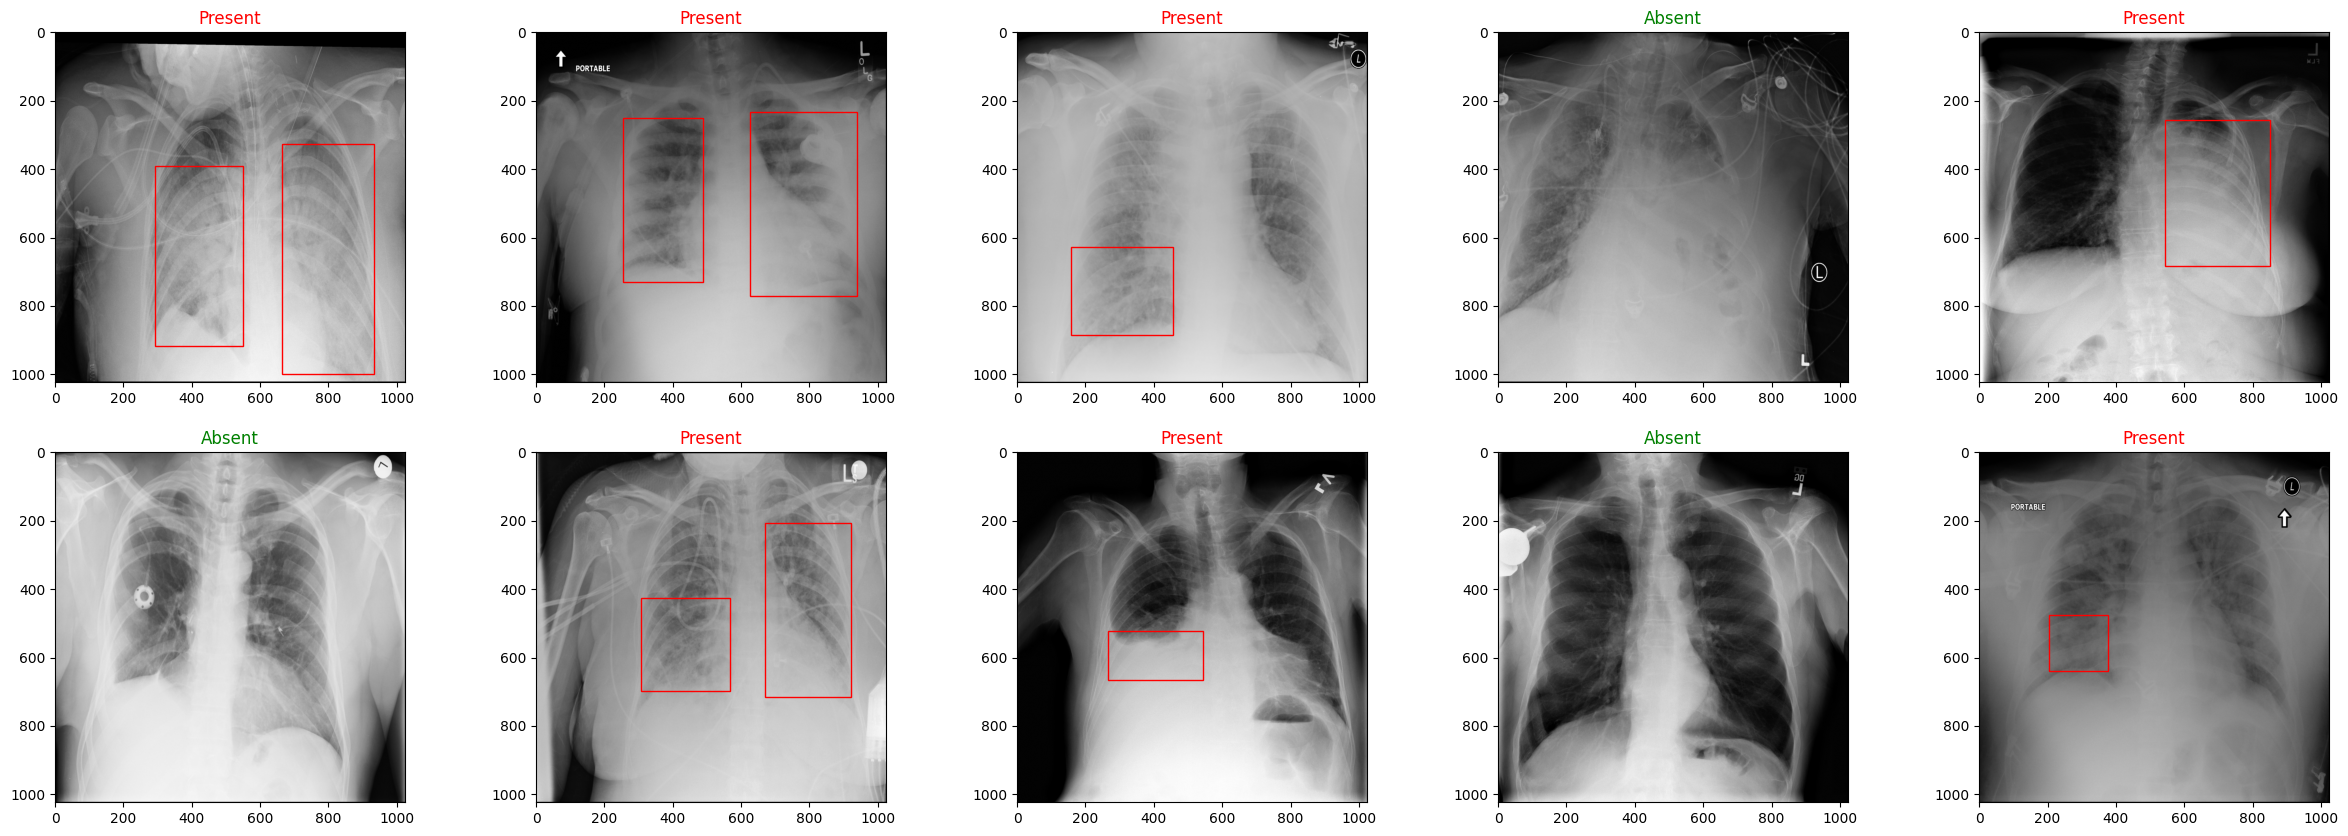

In [12]:
# Print out the randomly sampled images in a subplot with a box to determine the pneumonia spots

from matplotlib.patches import Rectangle

plt.figure(figsize=(30, 10))

for i in range(len(rand_int_list)):
    plt.subplot(rows, columns, i+1)

    random_int = rand_int_list[i]
    
    # get the random images and their pixel values
    image_path = train_images_path[random_int]
    image = pydicom.dcmread(image_path)
    image_pixel = image.pixel_array

    # get the patient Id of the images
    Id = image.PatientID

    # search for the labels of those patientId in the label file
    label_data = df_label_file[df_label_file['patientId'] == Id]

    # Loop for the case that the image has multiple labels representing multiple spots(multiple coordinate data of spots) of pneumonia spots
    for index in range(len(label_data)):
        all_data = label_data.iloc[index]

        # If the label of the image has pneumonia we use the (coordinated data) data from the label document to draw a box at where the pneumonia spot is at
        if all_data['Target'].item() == 1:
            x, y, width, height = all_data['x'].item(), all_data['y'].item(), all_data['width'].item(), all_data['height'].item()
            rect = Rectangle([x, y], width=width, height=height, facecolor='none', edgecolor='red')
            # print(x, y, width, height)
            plt.gca().add_patch(rect)

            # plt.scatter(x, y)
            # plt.scatter(x+width, y)
            # plt.scatter(x, y+height)
            # plt.scatter(x+width, y+height)

    plt.imshow(image_pixel, cmap='gray')
    # image_label = labels_o_list[random_int]

    # We do .iloc[0] cuz, if the label is single it will just index to that single label but if it has multiple label then it will go to the first label, and see its target which is same as its other label. 
    # Also if we try to get the 'Target' value of the label data when it has multiple label then we will get error. so this indexing is important.
    image_label = label_data.iloc[0]['Target']

    color = 'green' if image_label == 0 else 'red'

    plt.title(labels_dict[image_label], color=color)

In [13]:
# 'labels_dict' corresponding to the labels and what the labels represent
list(labels_dict.keys()), labels_dict

([0, 1], {0: 'Absent', 1: 'Present'})

In [14]:
# We are trying to get the label of the image in the format of [class(either 0 or 1), x, y, width, height, conf_score]
# conf_score or confidence score refers to the probability of class in the image

In [15]:
image = pydicom.dcmread(train_images_path[0])
image.pixel_array
imageID = image.PatientID



label = df_label_file[df_label_file['patientId'] == imageID]

display(label)

img_label = label['Target'].item()
display(img_label)
x, y, w, h  = label['x'].item(), label['y'].item(), label['width'].item(), label['height'].item()
# label = list(label)
# list(label.iloc[0])
# list(label.Target)


# Get the label in the shape of [class label, x, y, width, height]
tensor = torch.tensor([img_label, x, y, w, h])
display(tensor)
# tensor.shape
tensor[0].dtype

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0


0

tensor([0., nan, nan, nan, nan])

torch.float32

In [16]:
index = 4

image = pydicom.dcmread(train_images_path[index])
image_ID = image.PatientID
# plt.imshow(image.pixel_array)
image_ID

label = df_label_file[df_label_file['patientId'] == image_ID]
# display(label.iloc[0]['Target'].item())
# display(label)
# display(len(df_label_file.columns))

print('__________')

if len(label) == 1:
    yolo_format_label = [label['Target'].item(), label['x'].item()]
    display(yolo_format_label)
else:
    all_label = []
    # for i in range(len(label)):
    #     yolo_format_label = [label.iloc[i]['Target'].item(), label.iloc[i]['x'].item(), label.iloc[i]['y'].item(), label.iloc[i]['width'].item(), label.iloc[i]['height'].item()]
    #     all_label.append(yolo_format_label)


    # loop throgh each of the label if the data has multiple labels corresponding to multiple bounding box
    for i in range(len(label)):
        yolo_format_label = [label.iloc[i]['Target'].item(), label.iloc[i]['x'].item(), label.iloc[i]['y'].item(), label.iloc[i]['width'].item(), label.iloc[i]['height'].item()]
        all_label.append(yolo_format_label)
        
    display(all_label)

all_label[0]

__________


[[1, 66.0, 160.0, 373.0, 608.0], [1, 552.0, 164.0, 376.0, 676.0]]

[1, 66.0, 160.0, 373.0, 608.0]

In [17]:
# Cusotumizable

## Create a custom dataset class

from torch.utils.data import Dataset

class CustomDataset(Dataset):

    # Initalize our custom dataset
    def __init__(self, data_path, transform, labels_dict, label_dataframe):
        super().__init__()
         
        # Create class attributes
        self.paths = list(Path(data_path).glob('*.dcm'))

        self.transform = transform

        # Attribute of the label file that is in panda dataframe format
        self.label_dataframe = label_dataframe

        self.classes = list(labels_dict.keys())
        self.classes_to_idx = labels_dict

    # Create a funtion to load image
    def load_image(self, index):
        # for index in range(len(self.paths)):
        "Opens an image via a path and returns it"
        image = pydicom.dcmread(self.paths[index])
        
        return image
    
    def __len__(self):
        '''Return the total number of data/samples'''
        return len(self.paths)
    
    def __getitem__(self, index):
        '''return one sample of data, data and label (X, y)'''

        # get a sample of dcm image 
        image_dcm = self.load_image(index)
    
        # and access its pixel value
        image = image_dcm.pixel_array

        # Also get the patienId so we can compare Id to the label corresponding to that Id
        image_Id = image_dcm.PatientID
        
        # get the label/labels for the sample image
        full_label = df_label_file[df_label_file['patientId'] == image_Id]
        # label might be multiple value(but same label of 1 i.e. pneumonia present) representing different pnueumonia spots in same image. Since all the labels will be same we will just pick the 1st one as label. This will work to give one label per image for both the single label image and multiple label image
        
        label = full_label.Target
        label = list(label)[0]

        if self.transform:
            return self.transform(image), label
        else:
            return image, label

In [18]:
## Create a custom dataset class

from torch.utils.data import Dataset

class CustomDataset(Dataset):

    # Initalize our custom dataset
    def __init__(self, data_path, transform, labels_dict, label_dataframe):
        super().__init__()
         
        # Create class attributes
        self.paths = list(Path(data_path).glob('*.dcm'))

        self.transform = transform

        # Attribute of the label file that is in panda dataframe format
        self.label_dataframe = label_dataframe

        self.classes = list(labels_dict.keys())
        self.classes_to_idx = labels_dict

    # Create a funtion to load image
    def load_image(self, index):
        # for index in range(len(self.paths)):
        "Opens an image via a path and returns it"
        image = pydicom.dcmread(self.paths[index])
        
        return image
    
    def __len__(self):
        '''Return the total number of data/samples'''
        return len(self.paths)
    
    def __getitem__(self, index):
        '''return one sample of data, data and label (X, y)'''

        # get a sample of dcm image 
        image_dcm = self.load_image(index)
    
        # and access its pixel value
        image = image_dcm.pixel_array

        # Also get the patienId so we can compare Id to the label corresponding to that Id
        image_Id = image_dcm.PatientID
        
        # get the label/labels for the sample image
        label = df_label_file[df_label_file['patientId'] == image_Id].Target
        # label might be multiple value(but same label of 1 i.e. pneumonia present) representing different pnueumonia spots in same image. Since all the labels will be same we will just pick the 1st one as label. This will work to give one label per image for both the single label image and multiple label image 
        label = list(label)[0]

        if self.transform:
            return self.transform(image), label
        else:
            return image, label

In [19]:
# Create path for train and test data
train_dir = Path(data_file/'stage_2_train_images')
test_dir = Path(data_file/'stage_2_test_images')

train_dir, test_dir

(WindowsPath('data/pneumonia_dataset/stage_2_train_images'),
 WindowsPath('data/pneumonia_dataset/stage_2_test_images'))

In [20]:
# Initalize a data transform to later apply to our dataset
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.ToTensor()
])

In [21]:
# Creates an instance of our CustomDataset class, `train_data` and `test_data`

train_data = CustomDataset(data_path=train_dir,
                           transform=data_transform,
                           labels_dict=labels_dict,
                           label_dataframe=df_label_file)

test_data = CustomDataset(data_path=test_dir,
                          transform=data_transform,
                          labels_dict=labels_dict,
                          label_dataframe=df_label_file)

In [22]:
df_label_file.iloc[:9]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1


In [23]:
# Check the sample of train data and display

data_sample, data_label = train_data[4]

display(data_sample.shape)
display(data_label)
# plt.imshow(data_sample.permute(1, 2, 0))

len(train_data), len(train_images_path)


torch.Size([1, 1024, 1024])

1

(26684, 26684)

In [24]:
### Create dataloader with the dataset(train data and test data)

from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE)

In [25]:
# Build a model architecture for the pnuemonia detection challenge

# We will do a classification model with object detection with the YOLO model. The object detection will help to get the bounding box for the pneumonia spots in the image

class PnuemoniaDetectionModel():
    def __init__(self):
        super().__init__()

    def forward(self,x):
        pass

In [26]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

In [28]:
results = model.train(
    data='dummy_data/data.yaml',
    epochs=5,
    imgsz=640,
    batch=1,
    name='pneumonia'
)

New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dummy_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pneumonia, nbs=64, nms=False, opset=None, optimize=False, 

train: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\dummy_data\labels\train.cache... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 118.30.0 MB/s, size: 63.3 KB)


val: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\dummy_data\labels\val.cache... 1 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]

WARNING Labels are missing or empty in C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\dummy_data\labels\val.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\pneumonia\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\pneumonia
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       1.3G      3.533      4.143      2.856          8        640: 100%|██████████| 1/1 [00:05<00:00,  5.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]

                   all          1          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels



c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\ultralytics\utils\metrics.py:731: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.34G      2.354      4.579       2.36          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 41.28it/s]

                   all          1          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels



c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\ultralytics\utils\metrics.py:731: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.35G      3.508      4.764      3.015          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.94it/s]

                   all          1          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels



c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\ultralytics\utils\metrics.py:731: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.36G      3.755      4.515       2.92          4        640: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 44.22it/s]

                   all          1          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels



c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\ultralytics\utils\metrics.py:731: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.38G      3.759       5.06      2.817          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 43.25it/s]

                   all          1          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels



c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\ultralytics\utils\metrics.py:731: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



5 epochs completed in 0.002 hours.
Optimizer stripped from c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\pneumonia\weights\last.pt, 6.2MB
Optimizer stripped from c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\pneumonia\weights\best.pt, 6.2MB

Validating c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\pneumonia\weights\best.pt...
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.70it/s]
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\ultralytics\utils\metrics.py:548: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\ultralytics\utils\metrics.py:593: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packag

                   all          1          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\.venv\Lib\site-packages\ultralytics\utils\metrics.py:731: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index


Speed: 0.6ms preprocess, 17.3ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\pneumonia


In [29]:
model.names

{0: 'pneumonia'}

In [30]:
result = model('dummy_data/images/train/img1.jpg')


image 1/1 c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\dummy_data\images\train\img1.jpg: 640x640 (no detections), 55.9ms
Speed: 3.5ms preprocess, 55.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [31]:
box = result[0].boxes

display(box.cls)
display(box.xywh)
display(box.conf)

tensor([], device='cuda:0')

tensor([], device='cuda:0', size=(0, 4))

tensor([], device='cuda:0')

In [32]:
import os

files = os.walk('dummy_data')


for x in files:
    print(x)

('dummy_data', ['images', 'labels'], ['data.yaml'])
('dummy_data\\images', ['train', 'val'], [])
('dummy_data\\images\\train', [], ['img1.jpg'])
('dummy_data\\images\\val', [], ['img2.jpg'])
('dummy_data\\labels', ['train', 'val'], ['train.cache', 'val.cache'])
('dummy_data\\labels\\train', [], ['img1.txt'])
('dummy_data\\labels\\val', [], ['img2.txt'])


In [33]:
model = YOLO('../runs/detect/pneumonia/weights/best.pt')

In [34]:
# result = model('dummy_data/images/train/img1.jpg')
result = model('Muku.webp')


image 1/1 c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\Muku.webp: 384x640 (no detections), 25.5ms
Speed: 2.1ms preprocess, 25.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


In [35]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

# result = model('Muku.webp')
result = model('german-shepherd.jpg')


image 1/1 c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\german-shepherd.jpg: 384x640 1 dog, 19.2ms
Speed: 1.8ms preprocess, 19.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


In [36]:
result[0].show()

In [37]:
box = result[0].boxes

In [38]:
display(box.xywh)
display(box.conf)
display(box.cls)

tensor([[1012.7141,  543.4590, 1059.7134, 1052.1138]], device='cuda:0')

tensor([0.9368], device='cuda:0')

tensor([16.], device='cuda:0')

In [39]:
print(model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [40]:
model.names[box.cls.item()]

'dog'

In [41]:
box.cls.item()

16.0

In [42]:
model.nc

80

In [82]:
from PIL import Image
import pandas as pd

In [80]:


for path in train_images_path:
    print(path)
    id = path.stem
    print(id)
    
    break

data\pneumonia_dataset\stage_2_train_images\0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
0004cfab-14fd-4e49-80ba-63a80b6bddd6


'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

In [103]:
label_file

label_csv = pd.read_csv(label_file)
display(label_csv.iloc[5, 4])
label_csv.iloc[0: 6]

np.float64(453.0)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [104]:
label_csv

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [106]:
label_csv[label_csv['patientId'] == id]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0


In [108]:
id = '09c48ba8-4f0b-483c-85ec-9246d7cc6177'
label_csv[label_csv['patientId'] == id]

,patientId,x,y,width,height,Target
720,09c48ba8-4f0b-483c-85ec-9246d7cc6177,193.0,242.0,309.0,453.0,1
721,09c48ba8-4f0b-483c-85ec-9246d7cc6177,566.0,251.0,309.0,459.0,1
